In [1]:
import os 
import sys
import pandas as pd
import numpy as np

directory = os.getcwd()
cwd = directory.replace('Strat_7', '\module_1')
sys.path.append(cwd)

import Preprocessing_functions as pf 
import calculateMaxDD 
import joblib
#os.getcwd()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
ticker = 'SPY'

df = pf.downlaod_symbol_data(ticker, period= '120mo')
try:
    df = df.drop(columns=['Stock Splits', 'Dividends', 'Capital Gains'])
except KeyError:
    print("Columns not available (see above line of code)")
    
df = pf.create_momentum_feat(df, symbol=ticker) ### need to inspect in more detail how the create momemntum features work and the shift in this case
df = pf.technical_indicators(df,MA_DIVERGENCE=True)
df = pf.format_idx_date(df)

#df['prev_close'] = df['Close'].shift(1)
#df['tom_open'] = df['Open'].shift(-1)

df['overnight_pct'] = (df['Open'].shift(-1) - df['Close']) / df['Close']
#df['overnight_pct'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1) WRONG - OVERFITTING!

df = df[df.index <= '2024-02-01']

df = df.dropna()

df.tail()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,MACD,diff_Close_8,diff_Close_25,diff_Close_50,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200,overnight_pct
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-26,481.41,482.93,480.38,481.24,76641600,0.213955,0.035313,-0.315739,0.528027,-0.179025,...,0.570428,4.80625,10.9224,20.4268,38.3126,48.28215,15.62055,17.8858,27.85535,0.000644
2024-01-29,481.55,485.20,481.00,485.05,61322800,0.114215,-0.726820,-0.757969,0.865622,-0.841996,...,0.737633,6.27375,13.8236,23.3610,41.6742,51.65875,17.08725,18.3132,28.29775,-0.001443
2024-01-30,484.35,485.39,483.90,484.67,58618400,0.092908,-0.066068,-0.214721,0.306970,-0.159124,...,0.730937,4.11750,12.7252,22.1314,40.8200,50.87370,18.01390,18.6886,28.74230,-0.004622
2024-01-31,482.43,482.89,476.74,476.76,126011100,1.179446,1.175300,-0.095351,1.273582,-0.004195,...,0.133380,-3.84750,4.4508,13.5408,32.5014,42.59325,17.38830,18.9606,29.05245,0.003629
2024-02-01,478.49,483.03,477.67,483.00,91891600,0.171372,-0.942548,-0.948818,1.109662,-1.115833,...,0.099524,1.68375,10.1560,18.9864,38.2770,48.43885,17.30265,19.2906,29.45245,0.000932


In [15]:
print('Start date of dataframe: ', df.index.min())
print('End date of dataframe: ', df.index.max())

Start date of dataframe:  2016-02-23 00:00:00
End date of dataframe:  2024-02-01 00:00:00


In [49]:
cols = df.columns

In [16]:

# Features and target
features = df.drop(columns=["overnight_pct"])
target = df["overnight_pct"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [17]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:

# Define Neural Network model
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x)


In [19]:

# Initialize model
input_dim = X_train.shape[1]
model = RegressionNN(input_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:

# Training loop
num_epochs = 10000
best_rmse = float("inf")
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, "best_model.pth")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluate model on test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor).item()
        test_rmse = np.sqrt(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Test RMSE: {test_rmse:.4f}")
    
    # Save best model
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        torch.save(model.state_dict(), best_model_path)

print(f"Training complete. Best model saved at {best_model_path}")

Epoch 1/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 2/10000, Train Loss: 0.0000, Test RMSE: 0.0082
Epoch 3/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 4/10000, Train Loss: 0.0000, Test RMSE: 0.0080
Epoch 5/10000, Train Loss: 0.0000, Test RMSE: 0.0082
Epoch 6/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 7/10000, Train Loss: 0.0000, Test RMSE: 0.0082
Epoch 8/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 9/10000, Train Loss: 0.0000, Test RMSE: 0.0082
Epoch 10/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 11/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 12/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 13/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 14/10000, Train Loss: 0.0000, Test RMSE: 0.0082
Epoch 15/10000, Train Loss: 0.0000, Test RMSE: 0.0082
Epoch 16/10000, Train Loss: 0.0000, Test RMSE: 0.0082
Epoch 17/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 18/10000, Train Loss: 0.0000, Test RMSE: 0.0081
Epoch 19/10000, Train Loss: 0.0000, T

In [26]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

RegressionNN(
  (model): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [60]:

df1 = pf.downlaod_symbol_data(ticker, period= '360mo')
try:
    df1 = df1.drop(columns=['Stock Splits', 'Dividends', 'Capital Gains'])
except KeyError:
    print("Columns not available (see above line of code)")
    
df1 = pf.create_momentum_feat(df1, symbol=ticker) ### need to inspect in more detail how the create momemntum features work and the shift in this case
df1 = pf.technical_indicators(df1,MA_DIVERGENCE=True)
df1 = pf.format_idx_date(df1)

#df['prev_close'] = df['Close'].shift(1)
#df['tom_open'] = df['Open'].shift(-1)

df1['overnight_pct'] = (df1['Open'].shift(-1) - df1['Close']) / df1['Close']
#df['overnight_pct'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1) WRONG - OVERFITTING!

df1 = df1[df1.index <= str(df.index.min())]

df1 = df1.dropna()

df1.tail()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,MACD,diff_Close_8,diff_Close_25,diff_Close_50,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200,overnight_pct
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-17,163.92,165.77,163.79,165.39,136009500,0.079307,-0.896779,-1.128599,1.194426,-0.976861,...,0.582687,5.01625,3.3284,-2.5090,-5.4904,-7.55755,-7.52525,-2.9814,-5.04855,0.001693
2016-02-18,165.67,165.73,164.40,164.72,102343000,0.766584,0.573429,-0.036217,0.802510,-0.194647,...,0.753237,3.90250,2.7120,-2.8998,-6.1633,-8.15950,-6.80230,-3.2635,-5.25970,-0.004796
2016-02-19,163.93,164.79,163.31,164.64,114793000,0.378210,-0.433112,-0.524614,0.898113,-0.814402,...,0.834201,3.11750,2.5232,-2.7206,-6.2458,-8.18125,-5.83810,-3.5252,-5.46065,0.009718
2016-02-22,166.24,167.17,166.17,167.02,103640300,0.042108,-0.469201,-0.559432,0.598193,-0.511524,...,1.009859,4.49500,4.8056,-0.1528,-3.9334,-5.75850,-4.64780,-3.7806,-5.60570,-0.004011
2016-02-23,166.35,166.63,164.79,164.91,111455300,0.937782,0.865645,-0.168320,1.104243,-0.072820,...,0.946818,1.63000,2.5412,-2.0602,-6.0889,-7.81170,-3.69020,-4.0287,-5.75150,-0.008793


In [61]:
df1 = df1[cols]
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'open_low', 'open_close',
       'open_high', 'high_low', 'low_close', 'high_close', 'gap', 'SPY_mom1',
       'SPY_mom2', 'SPY_mom3', 'SPY_mom4', 'SPY_mom5', 'SPY_mom10',
       'SPY_mom15', 'SPY_mom20', 'SPY_mom60', 'SPY_mom120', 'SPY_mom180',
       'SPY_mom240', 'ATR', 'MACD', 'diff_Close_8', 'diff_Close_25',
       'diff_Close_50', 'diff_Close_100', 'diff_Close_200', 'diff_8_50',
       'diff_50_100', 'diff_50_200', 'overnight_pct'],
      dtype='object')

In [62]:
unseen_data = torch.tensor(scaler.transform(df1.drop(columns=['overnight_pct'])), dtype=torch.float32)

In [63]:
with torch.no_grad():
    predictions = model(unseen_data)
predicted_overnight_pct = predictions.numpy()

In [64]:
df1['predictions'] = predicted_overnight_pct 
df1['overnight_pct'] = (df1['Open'].shift(-1) - df1['Close']) / df1['Close']
df1['action'] = np.where(df1['predictions'] > 0, 'BUY', 'SELL')
df1.tail()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,diff_Close_25,diff_Close_50,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200,overnight_pct,predictions,action
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-17,163.92,165.77,163.79,165.39,136009500,0.079307,-0.896779,-1.128599,1.194426,-0.976861,...,3.3284,-2.5090,-5.4904,-7.55755,-7.52525,-2.9814,-5.04855,0.001693,-0.005860,SELL
2016-02-18,165.67,165.73,164.40,164.72,102343000,0.766584,0.573429,-0.036217,0.802510,-0.194647,...,2.7120,-2.8998,-6.1633,-8.15950,-6.80230,-3.2635,-5.25970,-0.004796,0.004128,BUY
2016-02-19,163.93,164.79,163.31,164.64,114793000,0.378210,-0.433112,-0.524614,0.898113,-0.814402,...,2.5232,-2.7206,-6.2458,-8.18125,-5.83810,-3.5252,-5.46065,0.009718,-0.001827,SELL
2016-02-22,166.24,167.17,166.17,167.02,103640300,0.042108,-0.469201,-0.559432,0.598193,-0.511524,...,4.8056,-0.1528,-3.9334,-5.75850,-4.64780,-3.7806,-5.60570,-0.004011,-0.007469,SELL
2016-02-23,166.35,166.63,164.79,164.91,111455300,0.937782,0.865645,-0.168320,1.104243,-0.072820,...,2.5412,-2.0602,-6.0889,-7.81170,-3.69020,-4.0287,-5.75150,NaN,-0.009131,SELL


In [65]:
df1.action.value_counts()

action
SELL    2812
BUY     2223
Name: count, dtype: int64

In [66]:
df1 = df1.dropna()
df1['prev_close'] = df1['Close'].shift()
df1['tom_open'] = df1['Open'].shift(-1)

#cols = df1.columns
#cols = [i for i in cols if i not in df.columns.remove]

#df1 = df1[cols]

df1.head()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200,overnight_pct,predictions,action,prev_close,tom_open
Date,,,,,,,,,,,,,,,,,,,,,
1996-02-22,39.34,39.86,39.31,39.74,721400,0.076258,-1.016777,-1.321810,1.379829,-1.093869,...,3.1749,4.98830,1.75295,1.0307,2.84410,0.005788,-0.004111,SELL,NaN,39.97
1996-02-23,39.97,40.03,39.26,39.63,1430400,1.776332,0.850638,-0.150113,1.923557,-0.942435,...,3.0162,4.83545,1.67500,1.0312,2.85045,-0.002776,0.003884,BUY,39.74,39.52
1996-02-26,39.52,39.60,39.05,39.07,1408400,1.189271,1.138664,-0.202429,1.388889,-0.051216,...,2.4134,4.23580,1.55305,1.0216,2.84400,0.002304,0.001939,BUY,39.63,39.16
1996-02-27,39.16,39.17,38.77,38.94,601000,0.995914,0.561798,-0.025536,1.021190,-0.438483,...,2.2416,4.06690,1.45580,1.0158,2.84110,0.007961,0.000955,BUY,39.07,39.25
1996-02-28,39.25,39.51,38.77,38.77,865900,1.222930,1.222930,-0.662420,1.872944,0.000000,...,2.0325,3.85960,1.37090,1.0091,2.83620,-0.005932,0.001115,BUY,38.94,38.54


Text(0, 0.5, 'Pct Difference')

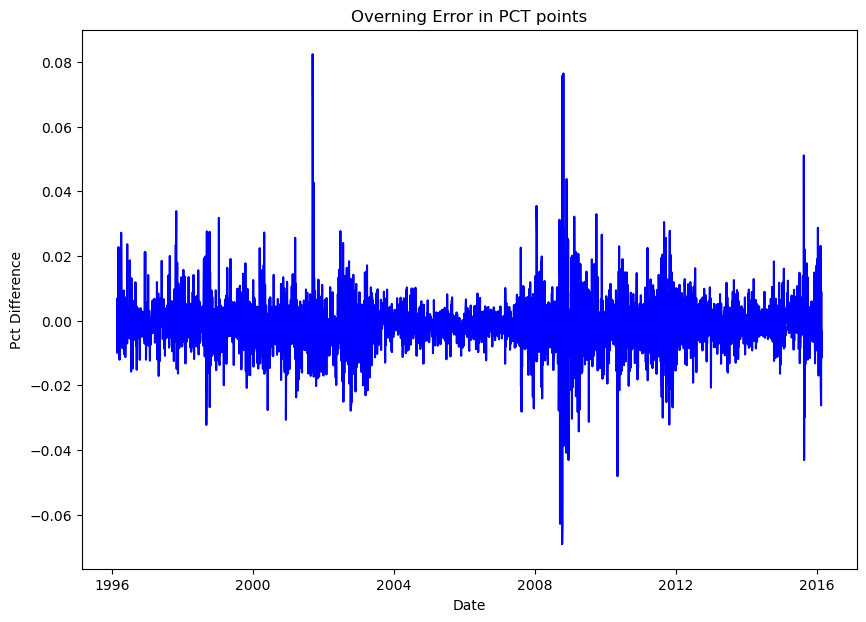

In [67]:
import matplotlib.pyplot as plt 

df1['error'] = df1['predictions'] - df1['overnight_pct']

plt.figure(figsize=[10,7])
plt.plot(df1.index, df1['error'] , color = 'b')
plt.title('Overning Error in PCT points')
plt.xlabel('Date')
plt.ylabel('Pct Difference')

Text(0, 0.5, 'Cummulative Return PCT')

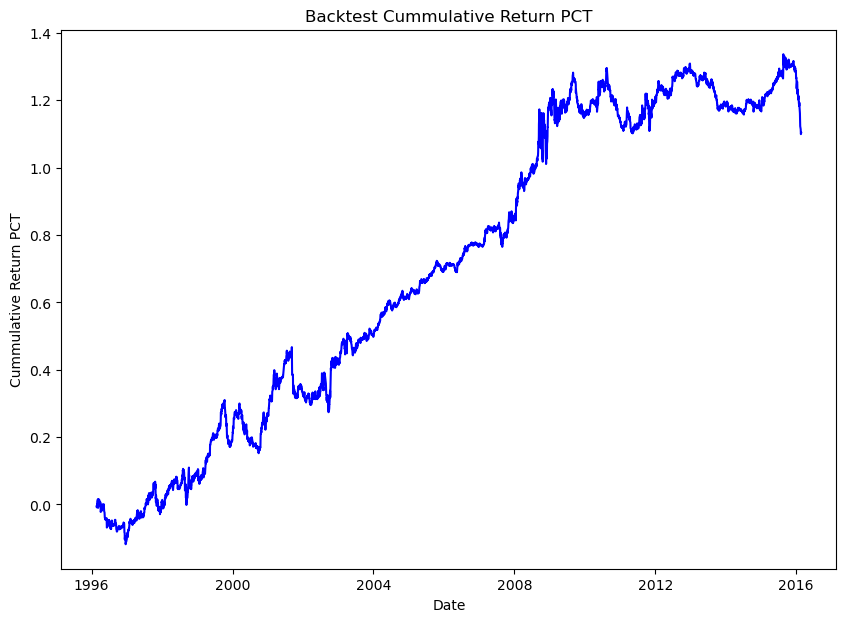

In [68]:
df1['return'] = np.where(df1['action'] == 'SELL', df1['overnight_pct'] * (-1), df1['overnight_pct'])
df1['cum_ret'] = df1['return'].cumsum()

plt.figure(figsize=[10,7])
plt.plot(df1.index, df1['cum_ret'] , color = 'b')
plt.title('Backtest Cummulative Return PCT')
plt.xlabel('Date')
plt.ylabel('Cummulative Return PCT')

In [69]:

#####   MAX DRAWDOWN
#from calculateMaxDD import calculateMaxDD

cum_ret = np.cumprod(1+ df1['return']) - 1
maxDrawdown, maxDrawdownDuration, startDrawdownDay=calculateMaxDD.calculateMaxDD(cum_ret.values)

#####   SHARPE RATIO
sharpe_ratio = round(np.sqrt(252) * np.mean(df1['return']) / np.std(df1['return']),2)

#####   AVG YEARLY RETURN AND STD
mean_ret = df1['return'].mean() * 252
std = df1['return'].std()*np.sqrt(252)

print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Maximum Drawdown: {round(maxDrawdown,4)}')
print(f'Max Drawdown Duration: {maxDrawdownDuration} days' )
print(f'Start day Drawdown: {startDrawdownDay}')
print(f"Average Yearly Return: {round(mean_ret*100, 2)} %")

Sharpe Ratio: 0.51
Maximum Drawdown: -0.2147
Max Drawdown Duration: 1262.0 days
Start day Drawdown: 5032
Average Yearly Return: 5.52 %
